In [1]:
from soma import aims 
import numpy as np 
import pandas as pd 
import os

In [8]:
### extracting regions of interest for cortical parcellation 

L_DKT = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/rel3_dhcp_anat_pipeline_analysis/sub-CC00529AN18/ses-170000/anat/sub-CC00529AN18_ses-170000_lh.DKT.label.gii'
R_DKT = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/rel3_dhcp_anat_pipeline_analysis/sub-CC00529AN18/ses-170000/anat/sub-CC00529AN18_ses-170000_rh.DKT.label.gii'

iMeshL = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/rel3_dhcp_anat_pipeline_analysis/sub-CC00529AN18/ses-170000/anat/sub-CC00529AN18_ses-170000_lh.white.surf.gii'
iMeshR = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/rel3_dhcp_anat_pipeline_analysis/sub-CC00529AN18/ses-170000/anat/sub-CC00529AN18_ses-170000_rh.white.surf.gii'

In [9]:
### LEFT CORTEX
tPARC_L = aims.read(L_DKT)
aPARC_L= np.array(tPARC_L)[0]

OUT_L = np.zeros_like(aPARC_L)
for label in [22,24,17]:
    OUT_L[aPARC_L == label] = label
    
mesh = aims.read(iMeshL)
tex = aims.TimeTexture('FLOAT')

for i in range(mesh.size()):
    vert = np.asarray(mesh.vertex(i))
    tex[i].assign(np.zeros((len(vert),), dtype=np.float32))
    t = np.asarray(tex[i])
    t[:] = OUT_L[:]
    aims.write(tex, '../../Results/sub-CC00529AN18_ses-170000_lh_cortical_parcels.gii')

### RIGHT CORTEX 
tPARC_R = aims.read(R_DKT)
aPARC_R= np.array(tPARC_R)[0]

OUT_R = np.zeros_like(aPARC_R)
for label in [22,24,17]:
    OUT_R[aPARC_R == label] = label
    
mesh = aims.read(iMeshR)
tex = aims.TimeTexture('FLOAT')

for i in range(mesh.size()):
    vert = np.asarray(mesh.vertex(i))
    tex[i].assign(np.zeros((len(vert),), dtype=np.float32))
    t = np.asarray(tex[i])
    t[:] = OUT_R[:]
    aims.write(tex, '../../Results/sub-CC00529AN18_ses-170000_rh_cortical_parcels.gii')

In [22]:
## subcortical

In [23]:
iVOL = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/rel3_dhcp_dmri_shard_pipeline_analysis/sub-CC00529AN18/ses-170000/sub-CC00529AN18_ses-170000.combined.DKT-DRAWEM.volume.shardDMRI.space.nii.gz'
tVOL = aims.read(iVOL)
aVOL = tVOL.arraydata()[0]

nVOL = np.zeros_like(aVOL)
for label in [41,40,47,46,19,43,42,87,86]:
    nVOL[aVOL == label] = label
    
## CAUD L == 41, R == 40
nVOL[nVOL == 40] = 41
## Lenti L==47, R==46
nVOL[nVOL == 46] = 47
#Thal final =43
nVOL[nVOL == 42] = 43
nVOL[nVOL == 87] = 43
nVOL[nVOL == 86] = 43

oVOL = aims.Volume(nVOL)
oVOL.header().update(tVOL.header())
aims.write(oVOL, '../../Results/sub-CC00529AN18_ses-170000_subcortical_parcels.nii.gz')

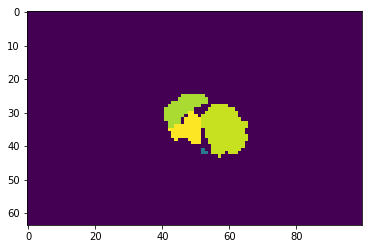

In [20]:
import matplotlib.pyplot as plt 
plt.imshow(nVOL[:,:,57])
plt.show()

In [4]:
## create example MD and RD maps fpr twp subjects 
controls = pd.read_csv('../../DerivedData/control_group_list.csv', header=None)
preterms = pd.read_csv('../../DerivedData/preterm_group_list.csv', header=None)

subjects = pd.concat([controls, preterms])
subjects = subjects[subjects[0].isin(['CC00529AN18', 'CC00731XX14'])]

In [12]:
for i, row in subjects.iterrows():
    print(row[0])
    #df_subj = pd.DataFrame()
    iDir = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/release3/dhcp_dmri_shard_pipeline/sub-{}/ses-{}/dwi/'.format(
                    row[0], row[1])
    # ceck that the diffusion directory exists 
    if os.path.isdir(iDir):
                  
        ## RD
        iPath2 = os.path.join(iDir, 'DTI/dtifit_b1000/sub-{}_ses-{}_L2.nii.gz'.format(
                                    row[0], row[1])) 
        iPath3 = os.path.join(iDir, 'DTI/dtifit_b1000/sub-{}_ses-{}_L3.nii.gz'.format(
                                    row[0], row[1])) 
        a2 = aims.read(iPath2).arraydata()[0]
        a3 = aims.read(iPath3).arraydata()[0]
        
        metric_map = (a2 + a3)/2
        
        new_im = aims.Volume(metric_map)
        new_im.header().update(aims.read(iPath2).header())

        aims.write(new_im, '../../Results/figures/{}_{}_RD.nii'.format(row[0], row[1]))
        
        if os.path.isfile('../../Results/figures/{}_{}_RD.nii'.format(row[0], row[1])):
                print('{} {} {} metric finished'.format(row[0], row[1], 'RD'))
        
        
        ## MD
        
        iPath1 = os.path.join(iDir, 'DTI/dtifit_b1000/sub-{}_ses-{}_L1.nii.gz'.format(
                                    row[0], row[1]))
        iPath2 = os.path.join(iDir, 'DTI/dtifit_b1000/sub-{}_ses-{}_L2.nii.gz'.format(
                                    row[0], row[1])) 
        iPath3 = os.path.join(iDir, 'DTI/dtifit_b1000/sub-{}_ses-{}_L3.nii.gz'.format(
                                    row[0], row[1])) 
        
        a1 = aims.read(iPath1).arraydata()[0]
        a2 = aims.read(iPath2).arraydata()[0]
        a3 = aims.read(iPath3).arraydata()[0]
        
        
        metric_map =( a1 + a2 + a3)/3
        
        new_im = aims.Volume(metric_map)
        new_im.header().update(aims.read(iPath2).header())

        aims.write(new_im, '../../Results/figures/{}_{}_MD.nii'.format(row[0], row[1]))
        
        if os.path.isfile('../../Results/figures/{}_{}_MD.nii'.format(row[0], row[1])):
                print('{} {} {} metric finished'.format(row[0], row[1], 'MD'))

CC00731XX14
CC00731XX14 214500 RD metric finished
CC00731XX14 214500 MD metric finished
CC00529AN18
CC00529AN18 170000 RD metric finished
CC00529AN18 170000 MD metric finished
